# 1. 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 2. 데이터 로드

In [3]:
google_trend_df = pd.read_csv('/content/drive/MyDrive/sogang_thesis_prj/dataset/total_google_trend.csv', index_col=0)
google_trend_df['date'] = pd.to_datetime(google_trend_df['date'])
google_trend_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16511 entries, 0 to 16510
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    16511 non-null  datetime64[ns]
 1   trend   16511 non-null  int64         
 2   artist  16511 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 516.0+ KB


In [5]:
artist_info_df = pd.read_csv('/content/drive/MyDrive/sogang_thesis_prj/dataset/top5_group_info.csv', index_col=0)
artist_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4839 entries, 0 to 4838
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   artist_name          4839 non-null   object 
 1   artist_id            4839 non-null   object 
 2   debut_date           4839 non-null   object 
 3   artist_types         4839 non-null   object 
 4   member_cnt           4839 non-null   int64  
 5   sub_group_cnt        4839 non-null   int64  
 6   label                4734 non-null   object 
 7   album_id             4839 non-null   object 
 8   album_name           4839 non-null   object 
 9   album_type           4839 non-null   object 
 10  release_date         4839 non-null   object 
 11  main_genre           0 non-null      float64
 12  sub_genre            0 non-null      float64
 13  track_cnt            4839 non-null   int64  
 14  avg_track_play_time  4749 non-null   float64
 15  participant_type     4839 non-null   object

In [6]:
google_trend_df['artist'].unique()

array(['aespa', 'BLACKPINK', 'BTS', 'IVE', 'NCT DREAM', 'NewJeans',
       'SEVENTEEN', 'Stray Kids', 'TOMORROW X TOGETHER', 'TWICE'],
      dtype=object)

In [7]:
google_trend_df.groupby('artist').count()['date'].sort_values()

artist
NewJeans                710
IVE                     973
aespa                  1345
SEVENTEEN              1836
BLACKPINK              1875
NCT DREAM              1890
TWICE                  1946
BTS                    1957
Stray Kids             1985
TOMORROW X TOGETHER    1994
Name: date, dtype: int64

In [8]:
# seasonal decompose 내 EDA 결과, NCT Dream의 경우 0값이 많으므로 해당 아티스트 제거
google_trend_df = google_trend_df[google_trend_df['artist'] != 'NCT DREAM']
google_trend_df

,date,trend,artist
0,2020-10-25,0,aespa
1,2020-10-26,0,aespa
2,2020-10-27,0,aespa
3,2020-10-28,0,aespa
4,2020-10-29,0,aespa
...,...,...,...
16506,2024-06-26,24,TWICE
16507,2024-06-27,23,TWICE
16508,2024-06-28,20,TWICE
16509,2024-06-29,34,TWICE


# 3. 전처리

In [9]:
google_trend_df.set_index('date', inplace=True)

In [10]:
# 0인 trend 값 interpolation 수행
google_trend_df.loc[google_trend_df['trend'] == 0, 'trend'] = np.NaN

# artist별 time interpolation & backward fill 수행
google_trend_df_list = []
for artist in google_trend_df['artist'].unique():

    single_artist_trend_df = google_trend_df.query(f"artist == '{artist}'")

    single_artist_trend_df['trend2'] = single_artist_trend_df['trend'].interpolate(method='time').fillna(method='bfill')
    google_trend_df_list.append(single_artist_trend_df)

google_trend_df2 = pd.concat(google_trend_df_list).reset_index()
google_trend_df2

,date,trend,artist,trend2
0,2020-10-25,NaN,aespa,8.0
1,2020-10-26,NaN,aespa,8.0
2,2020-10-27,NaN,aespa,8.0
3,2020-10-28,NaN,aespa,8.0
4,2020-10-29,NaN,aespa,8.0
...,...,...,...,...
14616,2024-06-26,24.0,TWICE,24.0
14617,2024-06-27,23.0,TWICE,23.0
14618,2024-06-28,20.0,TWICE,20.0
14619,2024-06-29,34.0,TWICE,34.0


In [11]:
artist_info_df[['artist_name', 'debut_date']].drop_duplicates().sort_values('debut_date')

,artist_name,debut_date
200,BTS,2013-06-13
0,SEVENTEEN,2015-05-26
1564,TWICE,2015-07-07
1739,BLACKPINK,2016-08-08
900,NCT DREAM,2016-08-24
650,Stray Kids,2017-10-17
1084,TOMORROW X TOGETHER,2019-01-10
1364,aespa,2020-10-25
1259,IVE,2021-11-01
1464,NewJeans,2022-07-22


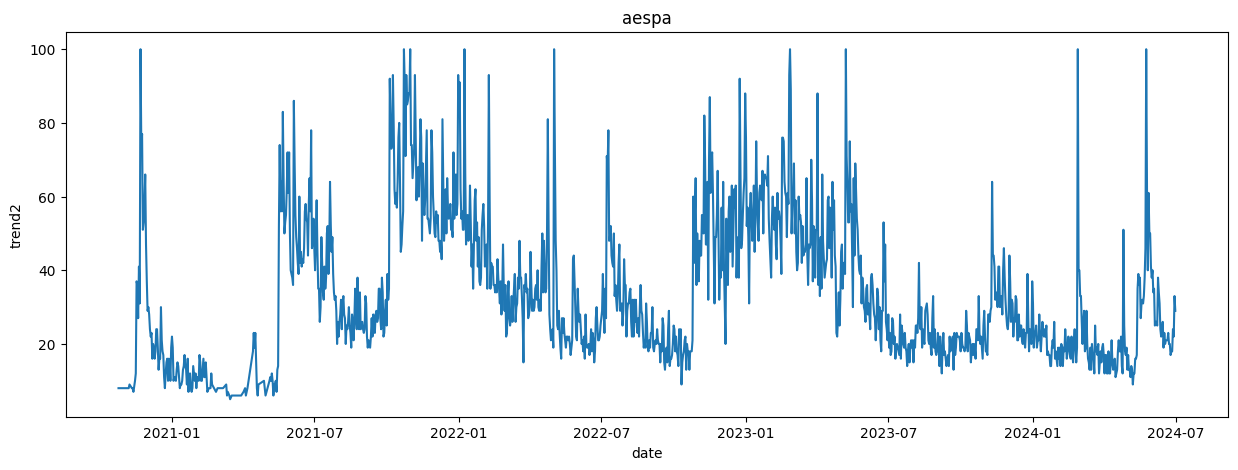

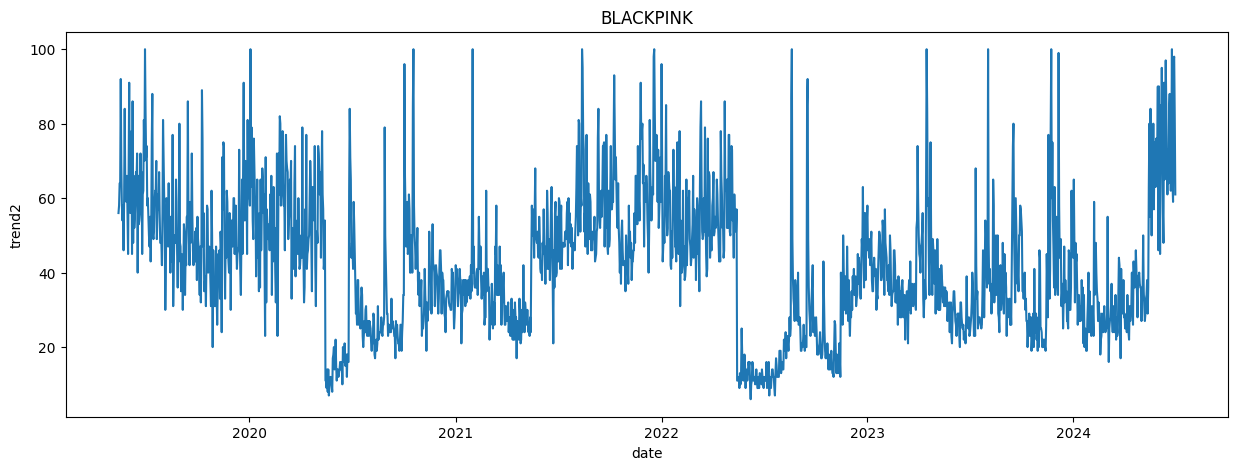

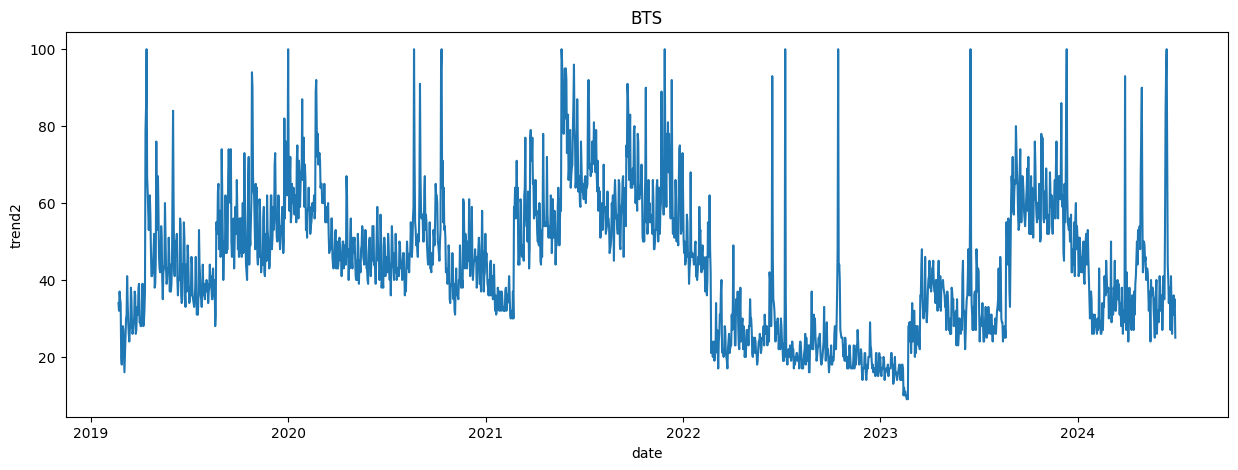

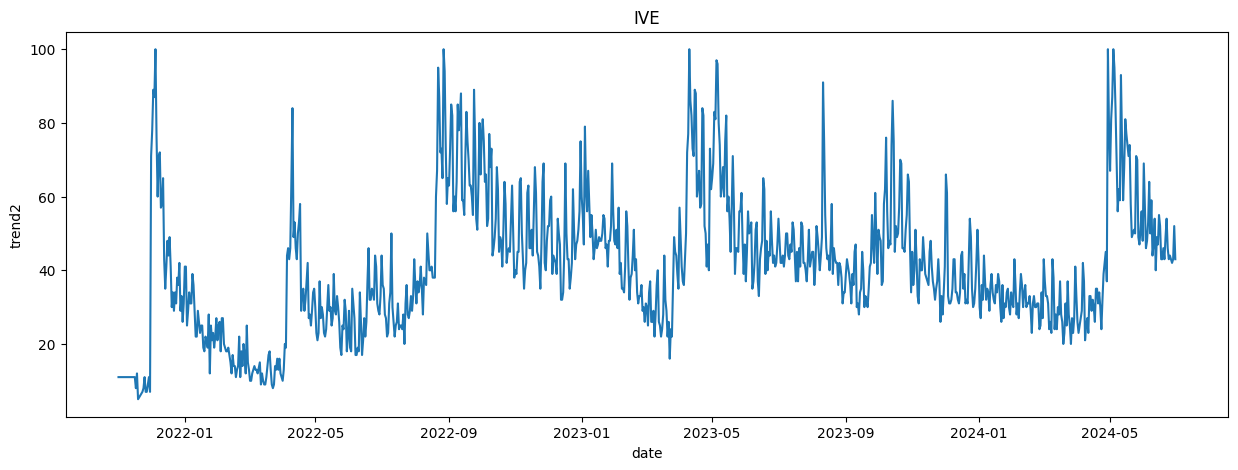

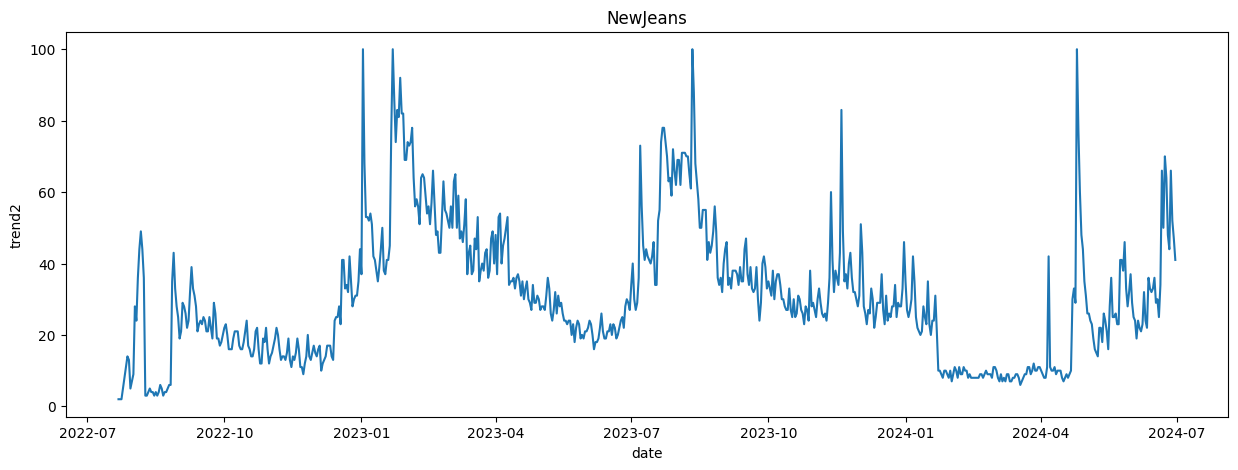

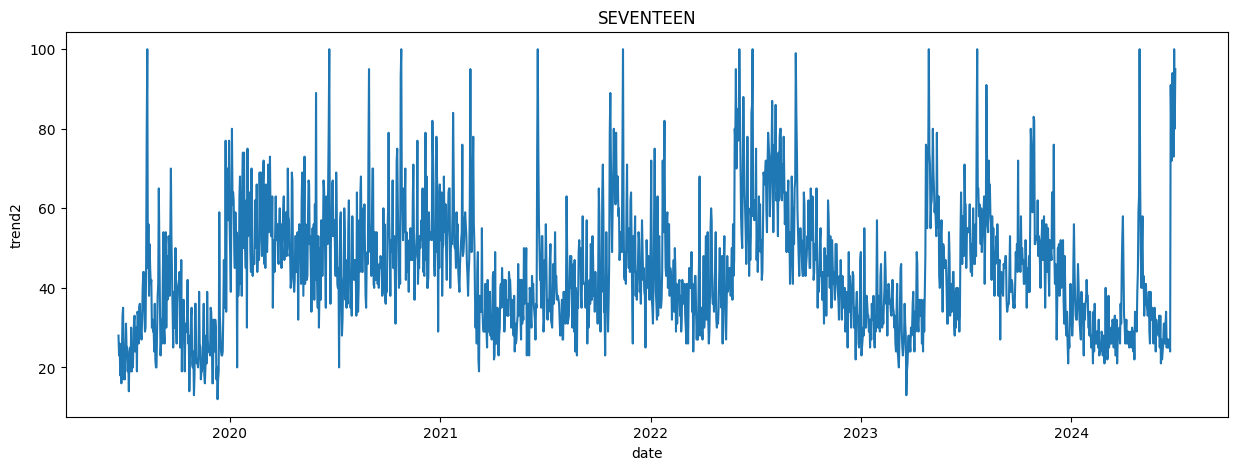

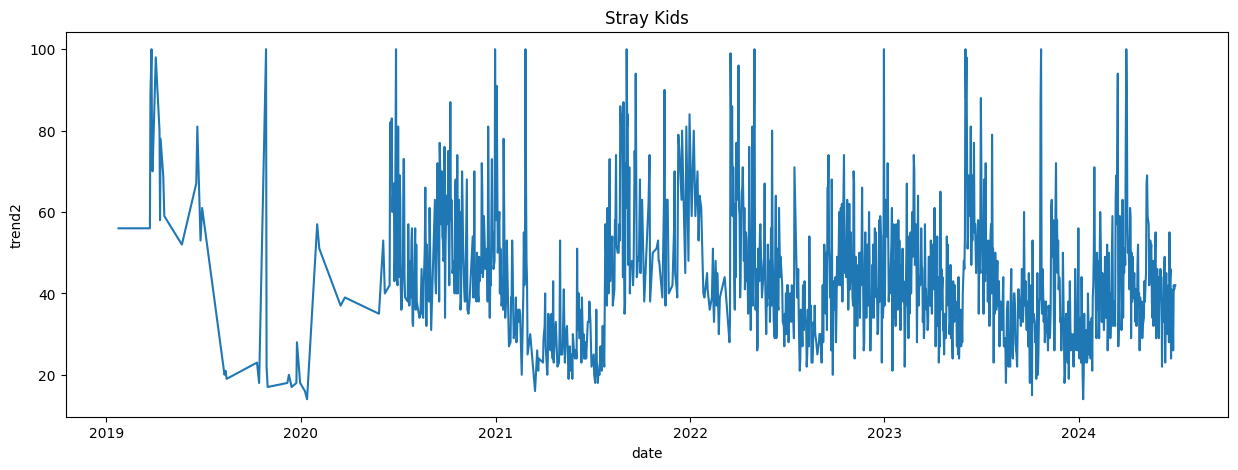

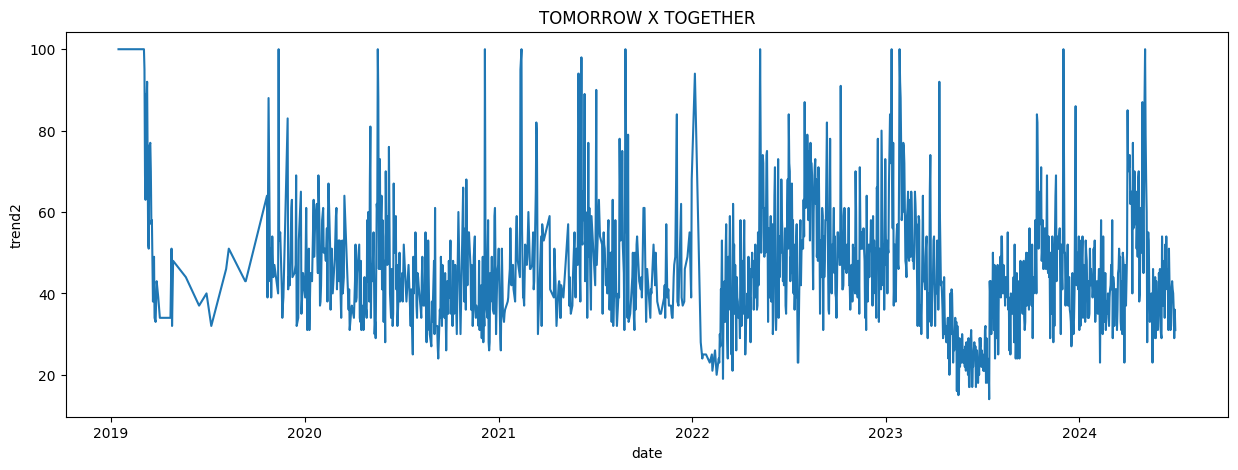

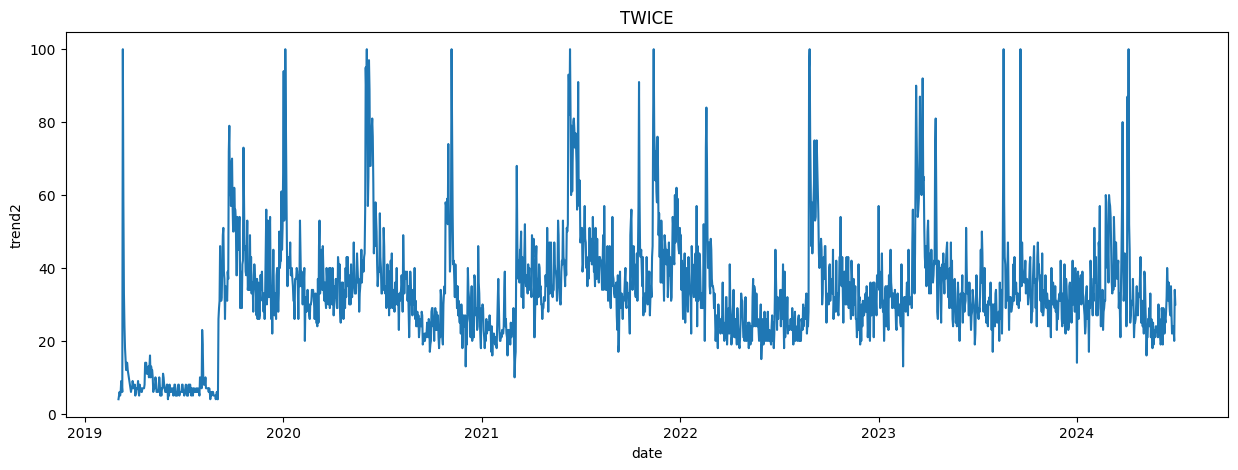

In [22]:
for artist in google_trend_df2['artist'].unique():

    plt.figure(figsize=(15, 5))

    plt.title(artist)
    sns.lineplot(
        data=google_trend_df2[google_trend_df2['artist'] == artist],
        x='date',
        y='trend2',
    )

    plt.show()

# 4. 정상성 검정
* p-value
  * 의미: p-value는 귀무가설(null hypothesis)이 맞을 확률을 나타내며, 일반적으로 귀무가설은 "데이터에 단위근이 존재한다"라는 가정을 의미
  * 단위근: 오늘의 영향력이 미래에 어느 정도 영향을 미치는지를 결정하는 모수
  * p-value < 0.05: 귀무가설을 기각합니다. 즉, 데이터가 정상성을 가진다고 판단할 수 있습니다.
  * p-value >= 0.05: 귀무가설을 기각하지 못합니다. 즉, 데이터가 비정상성을 가진다고 판단할 수 있습니다.

* ADF Statistic
  * 의미: ADF 통계량은 시계열 데이터에 단위근이 존재하는지 여부를 판단하는 데 사용되는 값입니다.
  * 해석: ADF 통계량이 음수일수록 데이터가 정상성을 가질 가능성이 높습니다. 이 값은 임계값과 비교하여 해석됩니다.
  * 1에 가까울수록 오늘의 영향력이 내일에 영향을 미칠 가능성이 크다는 것을 뜻함. 비정상성을 띈다고 해석

* ACF & PACF
  * ACF: 현재 값과 과거 값들 사이의 상관관계 측정
  * PACF: 특정 시차에서의 부분 자기상관 측정
  * ARIMA 모델의 p, d, q 파라미터 최적 차수 탐색 시 유용하게 사용됨

In [13]:
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 12.8 MB/s eta 0:00:00


In [14]:
from statsmodels.tsa.stattools import adfuller

In [21]:
'''
  - NewJeans의 경우, p-value값, ADF Statistic 값 보았을 때, 비정상성을 갖는 데이터로 파악됨
'''
for artist in google_trend_df2['artist'].unique():

    trend_df = google_trend_df2[google_trend_df2['artist'] == artist]

    result = adfuller(trend_df['trend2'])
    print(f"<<< {artist} >>>")
    print(f"ADF Statistic = {result[0]}")
    print(f"p-value = {result[1]}")
    print(f"Critical Values = {result[4]}")

    print('\n')

<<< aespa >>>
ADF Statistic = -3.529332670177638
p-value = 0.007264961301370295
Critical Values = {'1%': -3.4353061595148073, '5%': -2.863728748588099, '10%': -2.567935298646666}


<<< BLACKPINK >>>
ADF Statistic = -4.0675746598479
p-value = 0.0010952046735624933
Critical Values = {'1%': -3.4338858460442006, '5%': -2.8631018778892563, '10%': -2.567601488519795}


<<< BTS >>>
ADF Statistic = -2.889208472004671
p-value = 0.046617373802929955
Critical Values = {'1%': -3.433742755820826, '5%': -2.8630387070112255, '10%': -2.5675678525598005}


<<< IVE >>>
ADF Statistic = -3.87250853333298
p-value = 0.0022467475229881783
Critical Values = {'1%': -3.4372521657769353, '5%': -2.864587159166059, '10%': -2.5683924808864265}


<<< NewJeans >>>
ADF Statistic = -2.1869665202613473
p-value = 0.21100981936778662
Critical Values = {'1%': -3.4398489271901713, '5%': -2.8657317673059395, '10%': -2.569002221596252}


<<< SEVENTEEN >>>
ADF Statistic = -4.648976261972932
p-value = 0.00010482414478239203
Cri

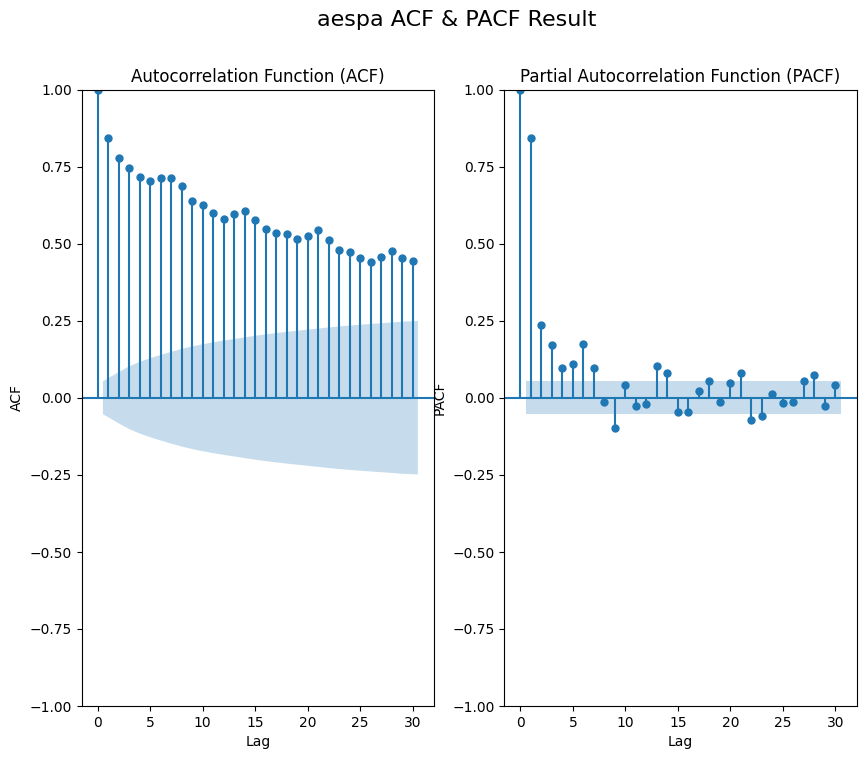

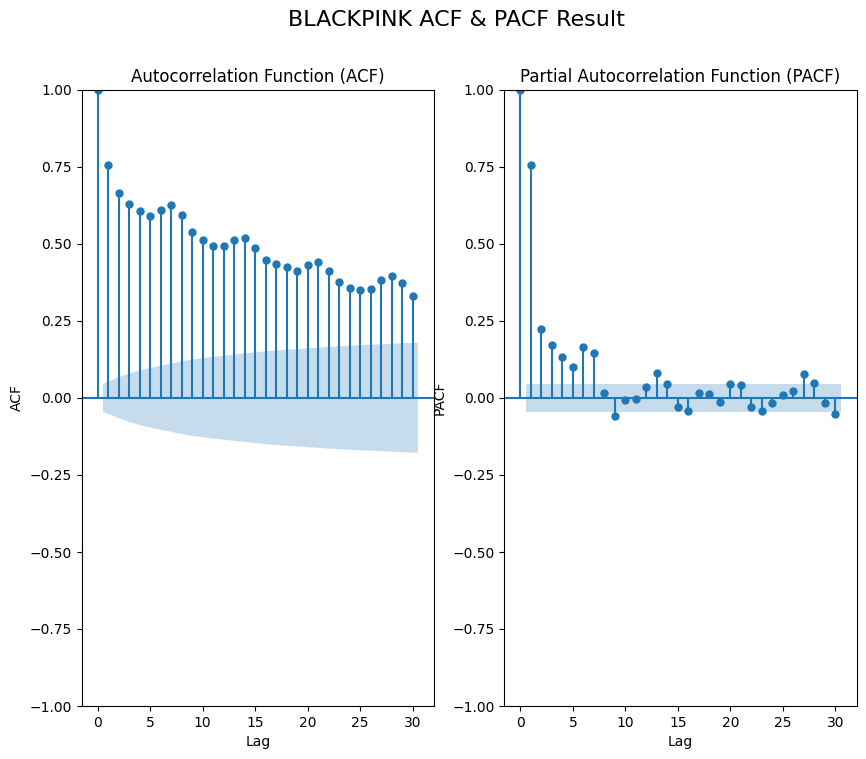

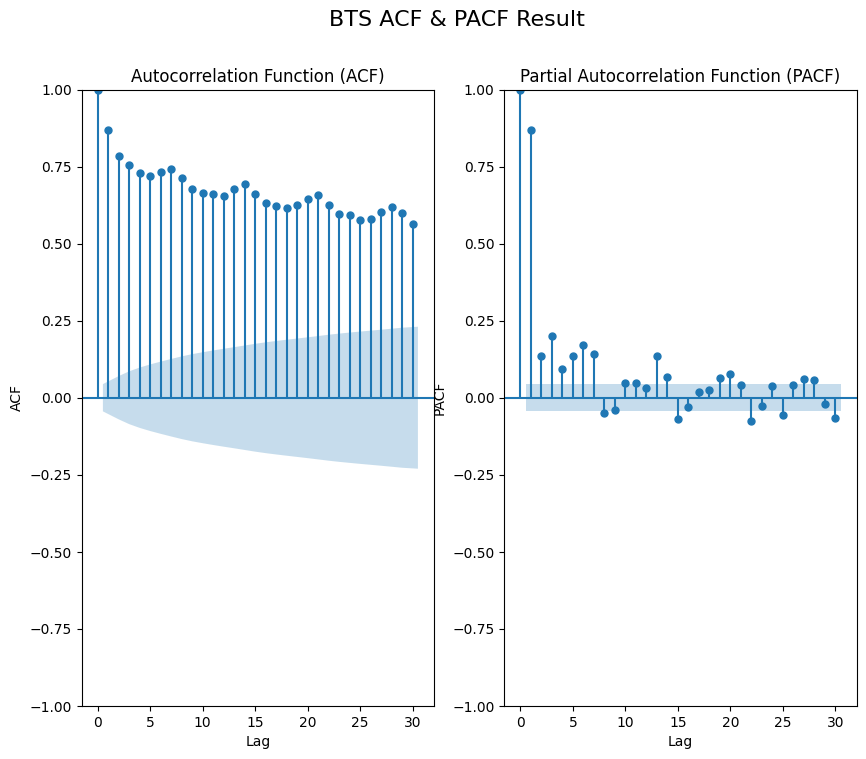

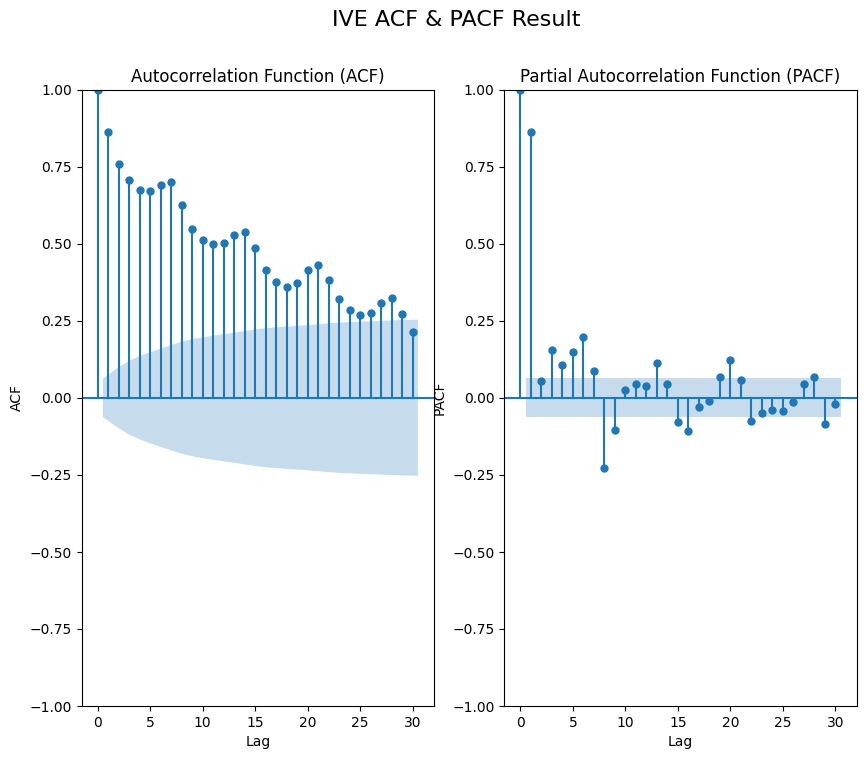

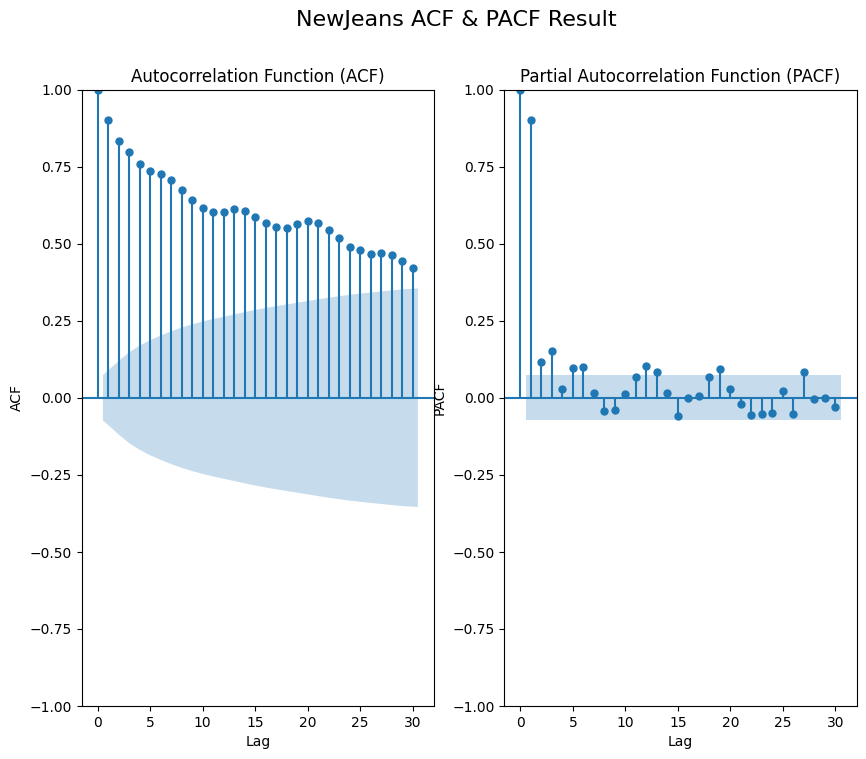

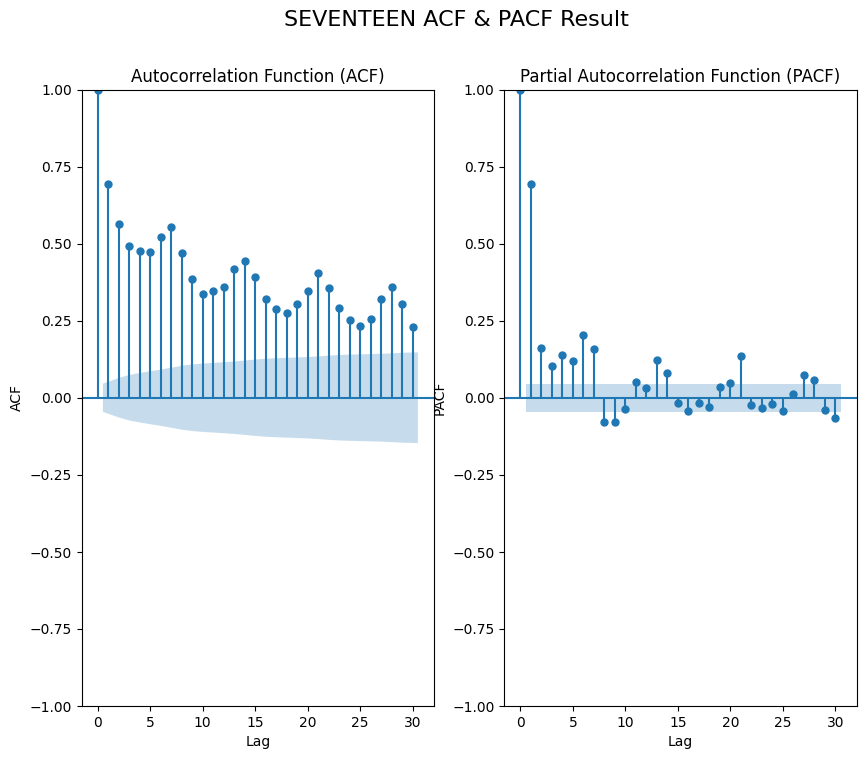

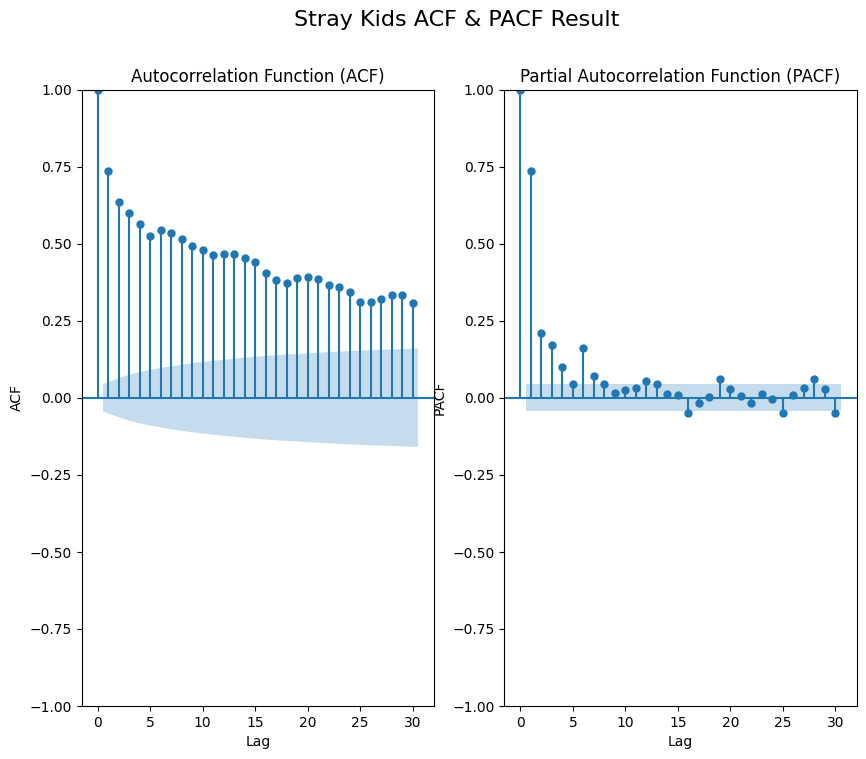

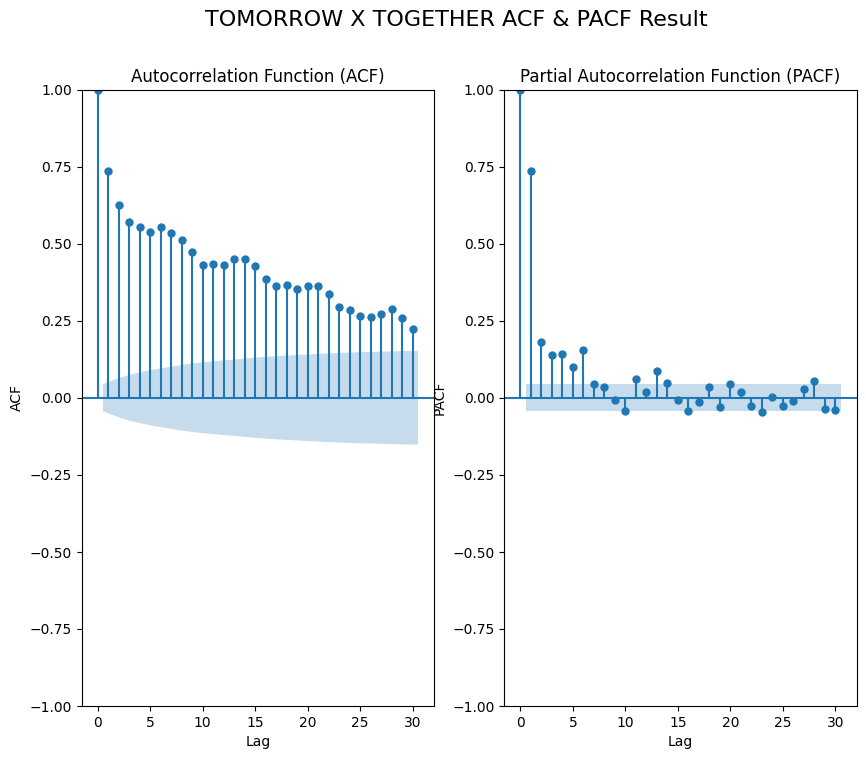

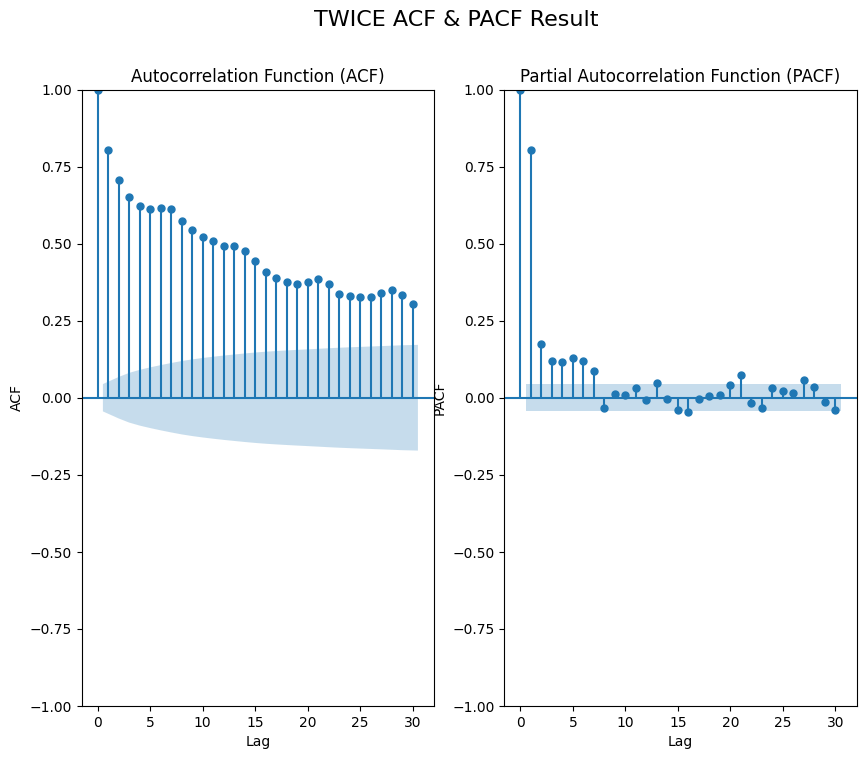

In [40]:
'''
  - ACF, PACF 검정
'''
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for artist in google_trend_df2['artist'].unique():

    trend_df = google_trend_df2[google_trend_df2['artist'] == artist]['trend2']
    # lag_num = np.round(len(trend_df) / 4) # 전체 시간의 4분의 1
    lag_num = 30

    # 시계열 데이터 생성 (예: 누적 합계로 단위근을 포함한 데이터)
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))
    plt.suptitle(f"{artist} ACF & PACF Result", fontsize=16)

    # ACF 시각화
    plot_acf(trend_df, lags=lag_num, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF)")
    axes[0].set_xlabel("Lag")
    axes[0].set_ylabel("ACF")

    # PACF 시각화
    plot_pacf(trend_df, lags=lag_num, method='ywm', ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF)")
    axes[1].set_xlabel("Lag")
    axes[1].set_ylabel("PACF")

    plt.show()